## Model Building

### Build model for predicting Price

In [1]:
#import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
#Read data
df = pd.read_csv('mubawab_listings_eda.csv')

In [3]:
df.head()

,Type,Localisation,Latitude,Longitude,Price,Area,Rooms,Bedrooms,Bathrooms,Floor,Other_tags,Price_m2,Current_state,Age
0,Appartements,Anfa,NaN,NaN,1230000,86.0,3.0,2.0,2.0,1.0,"['Bon état', '10-20 ans']",14302.325581,Bon état,10-20 ans
1,Appartements,La Gironde,NaN,NaN,900000,86.0,3.0,2.0,1.0,5.0,"['Bon état', '10-20 ans']",10465.116279,Bon état,10-20 ans
2,Appartements,Bourgogne Ouest,NaN,NaN,2400000,180.0,5.0,3.0,3.0,3.0,"['Bon état', '10-20 ans']",13333.333333,Bon état,10-20 ans
3,Appartements,Les princesses,33.574209,-7.644182,1550000,120.0,5.0,3.0,2.0,5.0,"['Bon état', '5-10 ans']",12916.666667,Bon état,5-10 ans
4,Appartements,Bourgogne Ouest,NaN,NaN,1450000,113.0,4.0,3.0,2.0,1.0,"['Bon état', '10-20 ans']",12831.858407,Bon état,10-20 ans


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           1250 non-null   object 
 1   Localisation   1250 non-null   object 
 2   Latitude       672 non-null    float64
 3   Longitude      672 non-null    float64
 4   Price          1250 non-null   int64  
 5   Area           1250 non-null   float64
 6   Rooms          1191 non-null   float64
 7   Bedrooms       1247 non-null   float64
 8   Bathrooms      1207 non-null   float64
 9   Floor          953 non-null    float64
 10  Other_tags     1250 non-null   object 
 11  Price_m2       1250 non-null   float64
 12  Current_state  1101 non-null   object 
 13  Age            715 non-null    object 
dtypes: float64(8), int64(1), object(5)
memory usage: 136.8+ KB


In [5]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price']
df_model = df[cols_to_keep]

In [6]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms             59
Bedrooms           3
Bathrooms         43
Floor            297
Current_state    149
Age              535
Price              0
dtype: int64

In [7]:
#drop listings where one of the four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [8]:
df_model.isna().sum()

Type               0
Localisation       0
Area               0
Rooms              0
Bedrooms           0
Bathrooms          0
Floor              0
Current_state     38
Age              240
Price              0
dtype: int64

In [9]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price'].values 

In [11]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

In [12]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [24]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler

In [14]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [16]:
#Scale the features using robust_scaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)

In [42]:
#define function to evaluate linear models
def evaluate_linear_model(X_train,y_train,X_test,y_test,reg,grid = False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score (R^2): {reg.score(X_train,y_train):.2f}')
    print(f'Test set score (R^2): {reg.score(X_test,y_test):.2f}')
    coef_matrix = pd.DataFrame(np.hstack([reg.intercept_,reg.coef_]).reshape(1,-1),columns = np.hstack(['Intercept',X_train.columns]))
    display(coef_matrix)
    
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])

    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = coef_matrix.columns,x = coef_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    

    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),'%')))
    #g = sns.jointplot(x = error_matrix[0,:], y= error_matrix[1,:],color = cust_pal[5], height = 8, ratio = 5)
    
    plt.tight_layout()
    plt.show()
    
cust_pal = sns.color_palette(sns.light_palette('#0d874b',10))

train RMSE : 1834254.19
test RMSE : 2662565.06
train MAPE : 0.2452
test MAPE : 0.2525
Training set score (R^2): 0.94
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.298985e+06,11053.389544,-84784.311397,-188929.796151,519362.127698,-22784.708028,-137457.455027,-105286.373834,-971405.136222,971405.136222,...,-523720.085161,-532892.878411,-1.341152e+06,-1.229378e+06,-199784.418136,-3.330259e+06,265033.470113,-1.497651e+06,195207.419647,-361096.554744


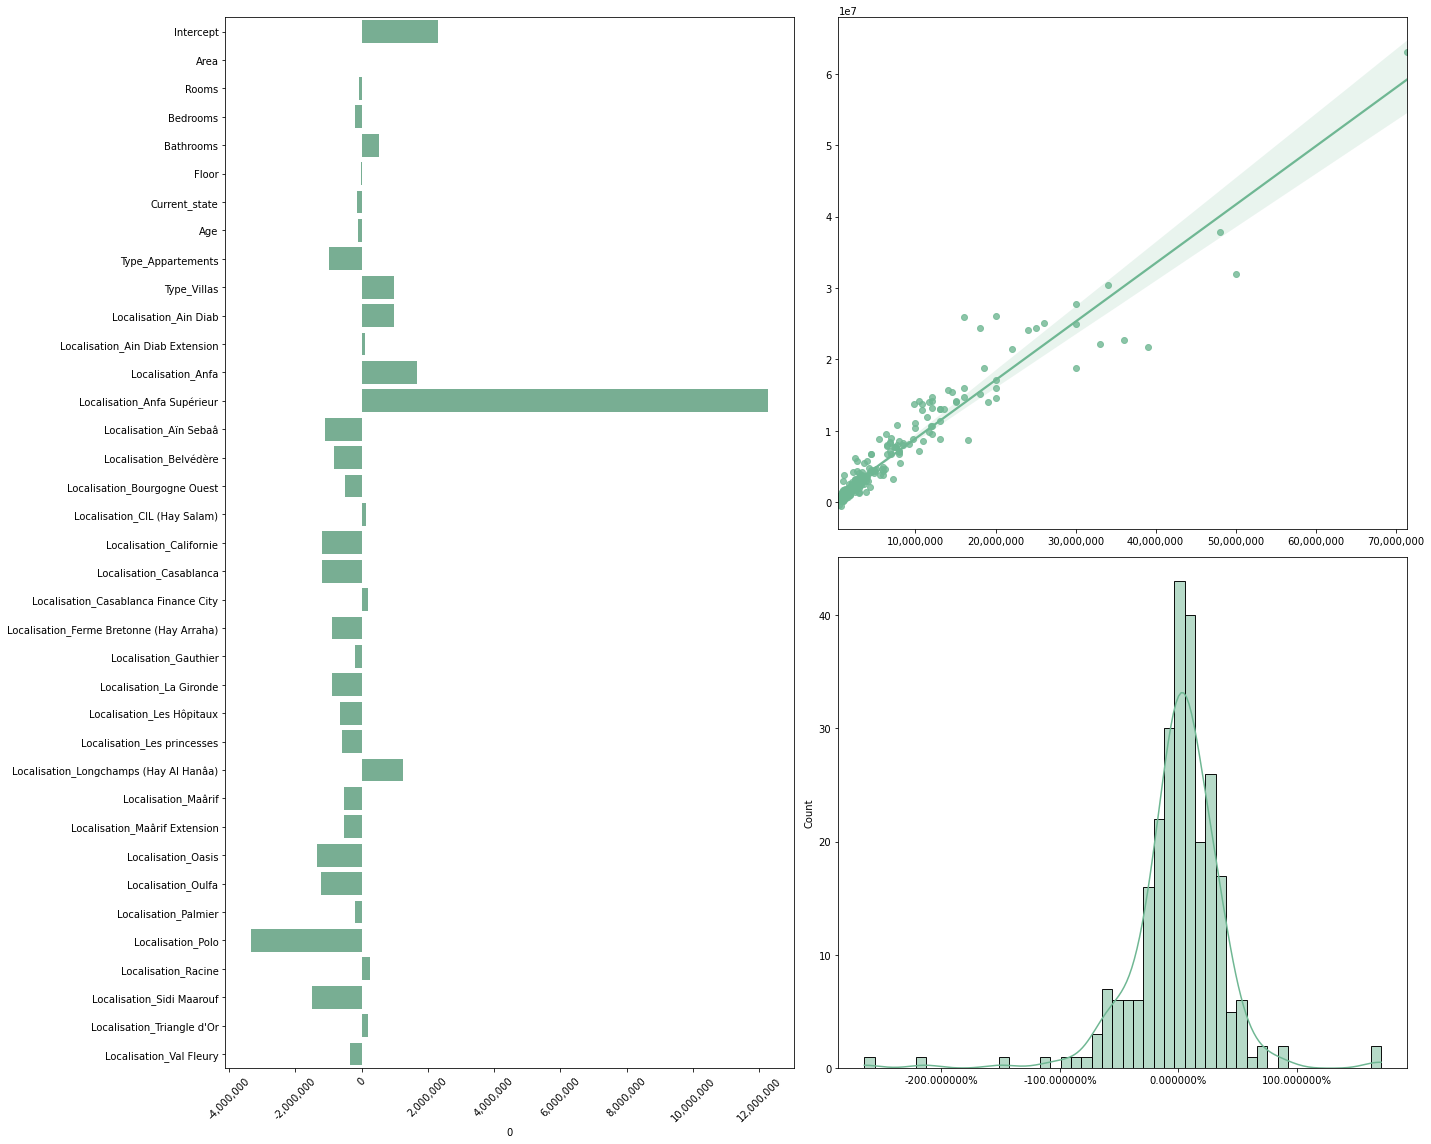

In [43]:
#Evaluate multivariate ols linear regression


linear_regression = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,linear_regression)

Best estimator parameters : {'alpha': 1}
train RMSE : 1841759.01
test RMSE : 2647722.11
train MAPE : 0.2437
test MAPE : 0.2523
Training set score (R^2): 0.94
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.279330e+06,11177.29554,-74847.223118,-209873.030087,507871.053566,-24270.809267,-129669.422287,-104908.140783,-1.001965e+06,1.001965e+06,...,-446406.313891,-459645.687622,-1.269400e+06,-1.119098e+06,-126802.642673,-3.178776e+06,316871.313115,-1.419235e+06,232267.770785,-285071.79848


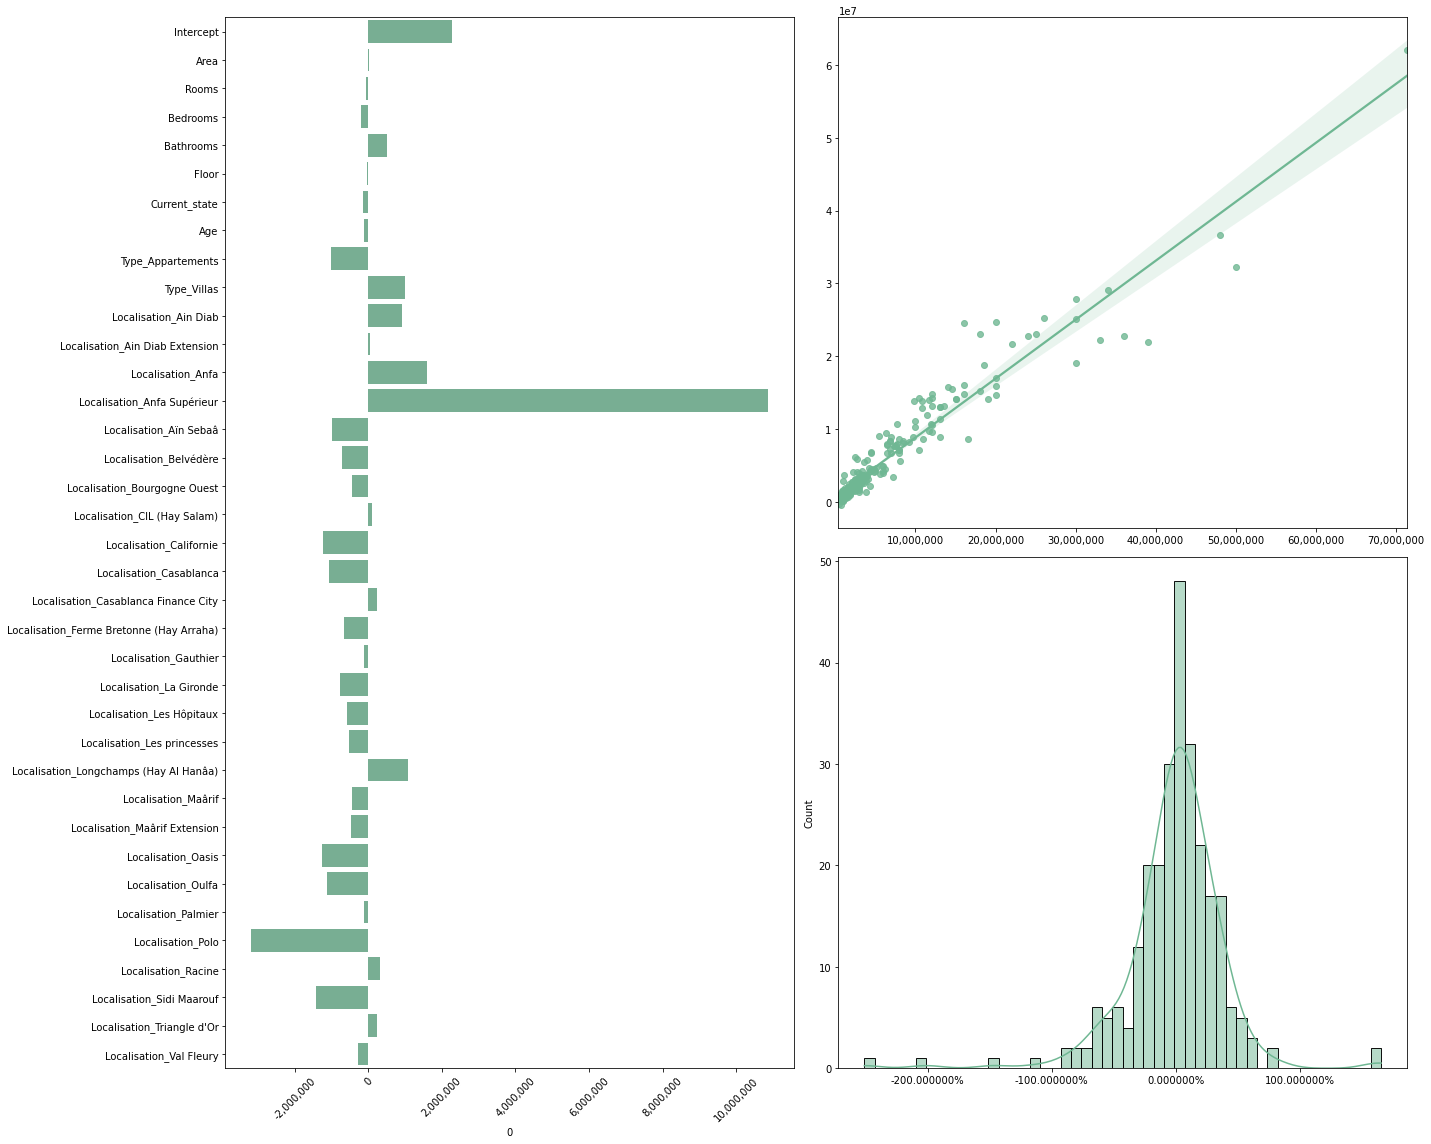

In [44]:
#Use a Ridge regression to introduce regularization
ridge = Ridge()
ridge_hyparams = {'alpha':[0.1,1,3,5]}
ridge_regression = GridSearchCV(ridge,ridge_hyparams,cv = 5)
evaluate_linear_model(X_train,y_train,X_test,y_test,ridge_regression,grid = True)

Best estimator parameters : {'alpha': 1}
train RMSE : 1841657.30
test RMSE : 2631529.21
train MAPE : 0.2432
test MAPE : 0.2602
Training set score (R^2): 0.94
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,2.503136e+06,3.561032e+06,-297280.020622,-415783.396834,507984.347474,-96282.492435,-130685.113462,-415602.028025,-1.004140e+06,1.004140e+06,...,-445809.153687,-458728.033075,-1.269714e+06,-1.120200e+06,-127931.394118,-3.176072e+06,315882.400825,-1.423480e+06,231022.113088,-286103.431833


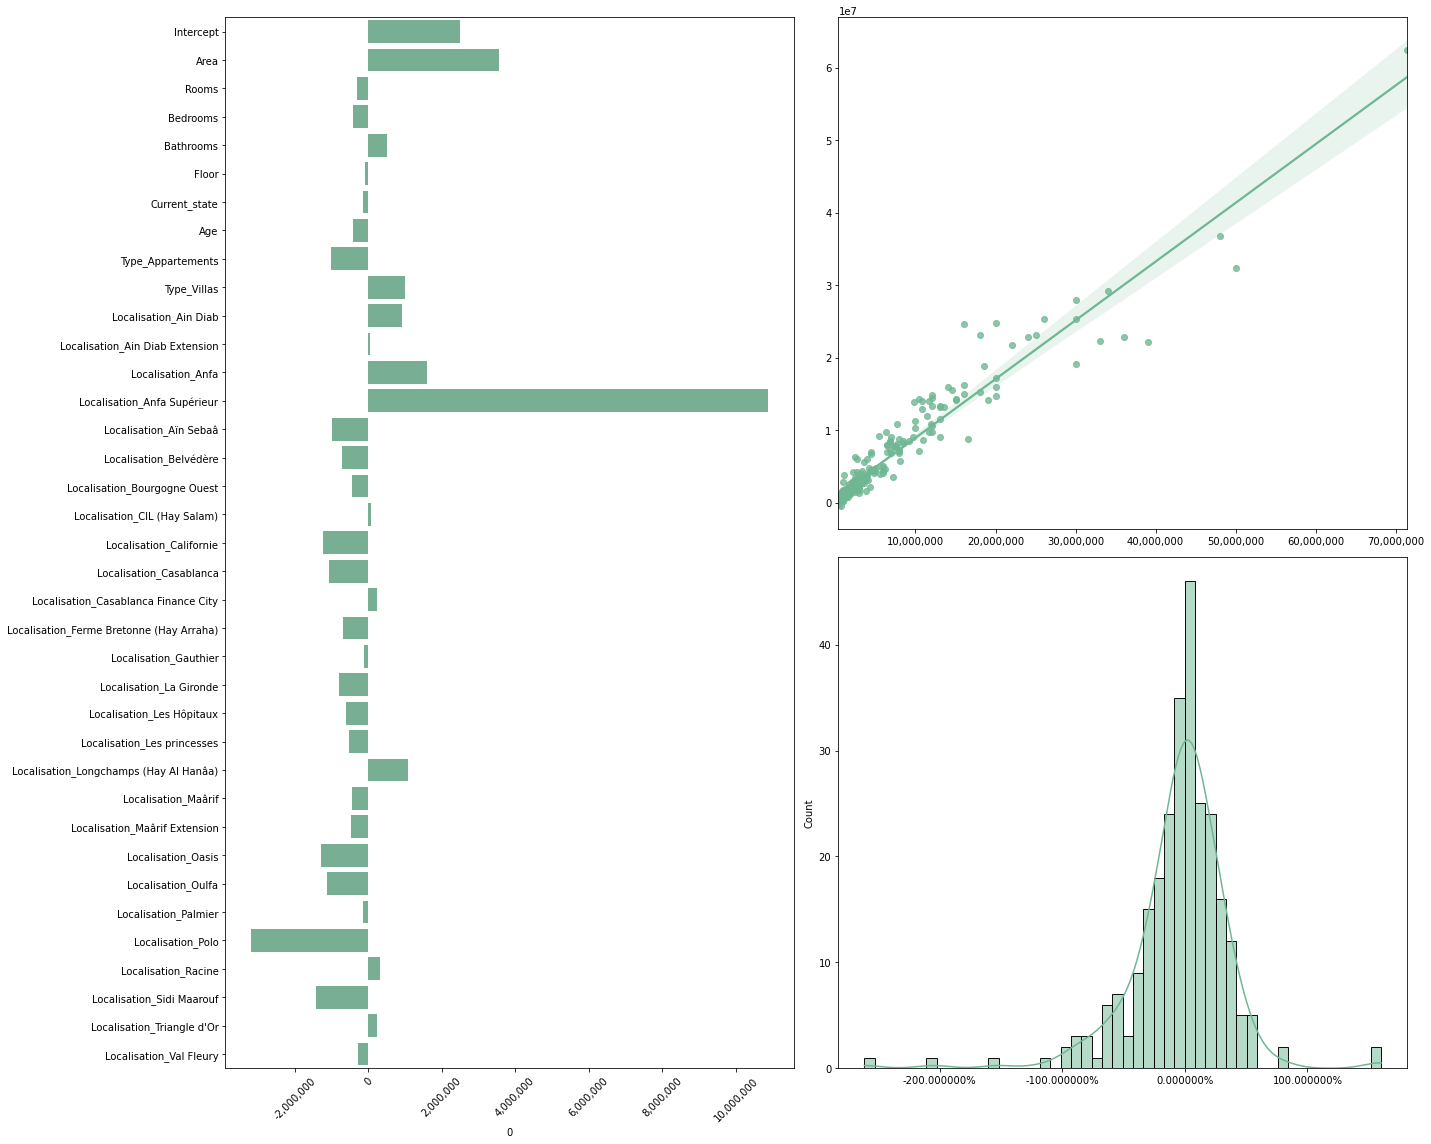

In [45]:
#Use a Ridge regression to introduce regularization with scaled data
evaluate_linear_model(X_train_scaled,y_train,X_test_scaled,y_test,ridge_regression,grid=True)

In [25]:
continuous_vars = ['Area','Rooms','Bedrooms','Bathrooms']

poly = PolynomialFeatures(degree = 2,include_bias = False)
poly = poly.fit(X[continuous_vars])
poly_df = pd.DataFrame(poly.transform(X[continuous_vars]),columns = poly.get_feature_names(continuous_vars))

In [26]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape

(887, 50)

In [27]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [28]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

train RMSE : 1578541.19
test RMSE : 2628620.64
train MAPE : 0.2227
test MAPE : 0.2943
Training set score (R^2): 0.95
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,2.401868e+06,3.100838e+06,344294.764613,314383.175343,-619168.854108,-101208.982313,-189015.642326,-486298.510068,-342406.885655,342406.885655,...,-32716.214574,308785.843837,-2.713414e+06,176188.734723,26229.915967,237197.86282,-1.480268e+06,-390701.6161,839462.464137,1.475263e+06


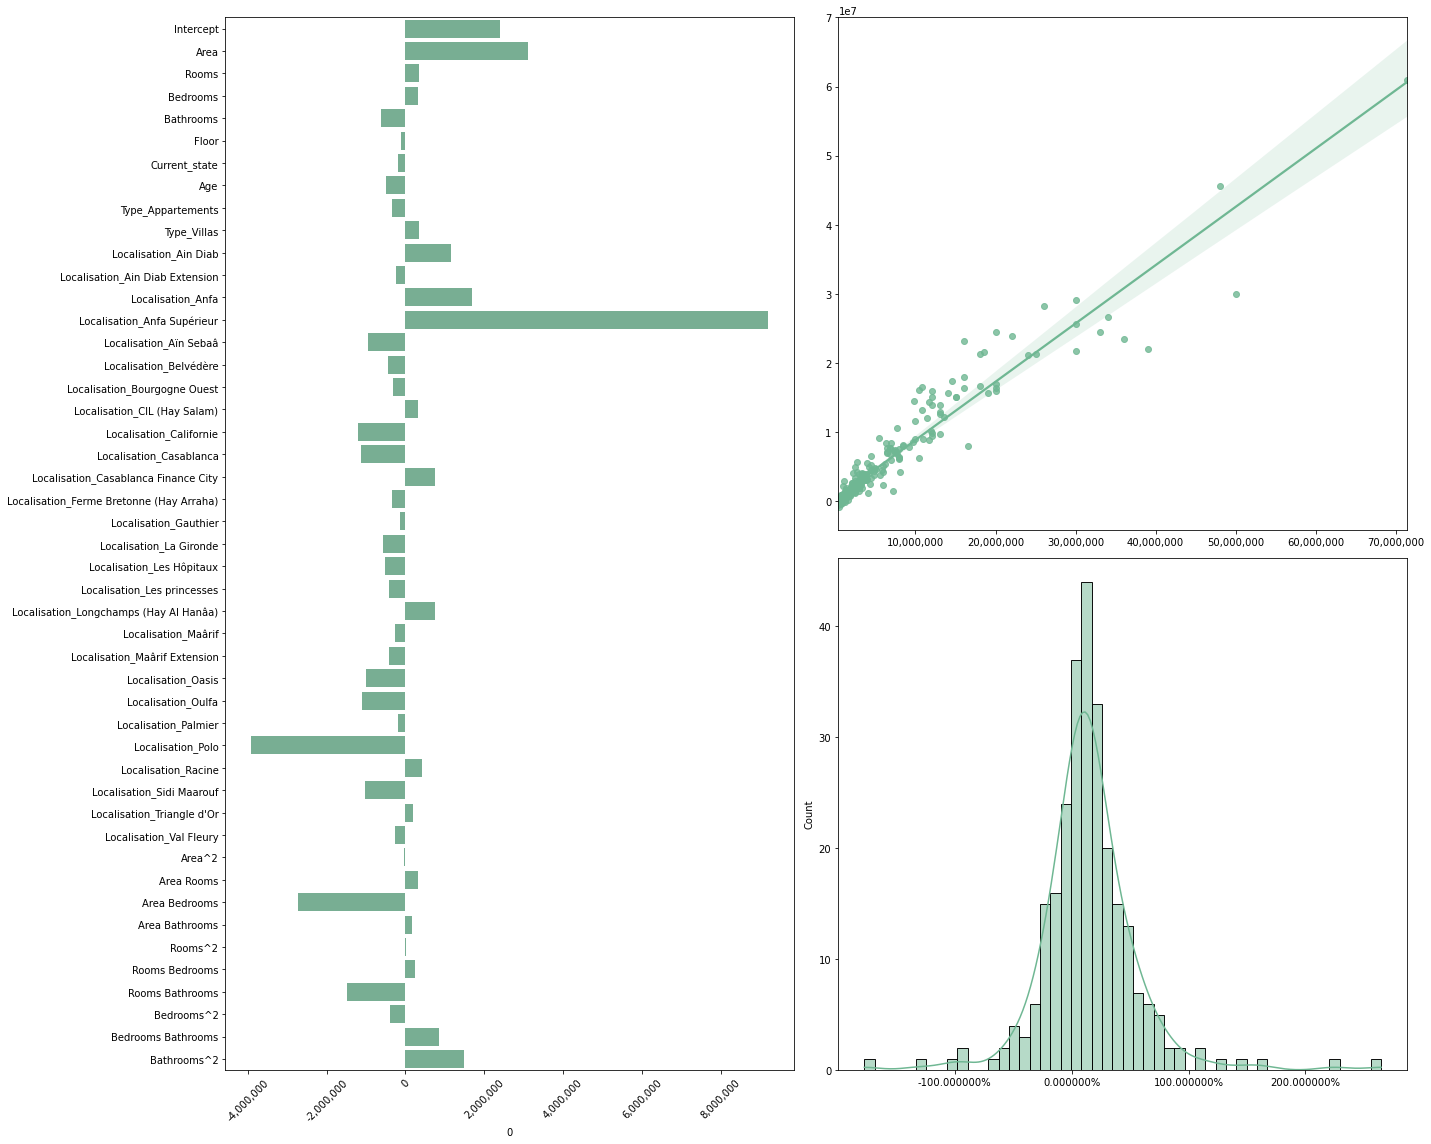

In [46]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

poly_linear_regression = LinearRegression()
poly_linear_regression.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,poly_linear_regression)

Best estimator parameters : {'alpha': 1}
train RMSE : 1584097.84
test RMSE : 2646569.14
train MAPE : 0.2186
test MAPE : 0.2869
Training set score (R^2): 0.95
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,2.375467e+06,3.134968e+06,349764.766149,313151.366213,-606607.005279,-105119.855351,-177186.692468,-486652.960078,-346178.170694,346178.170693,...,-31976.144472,329196.63043,-2.660207e+06,87175.075941,2850.269658,98979.971533,-1.342355e+06,-305647.267935,698497.697012,1.487576e+06


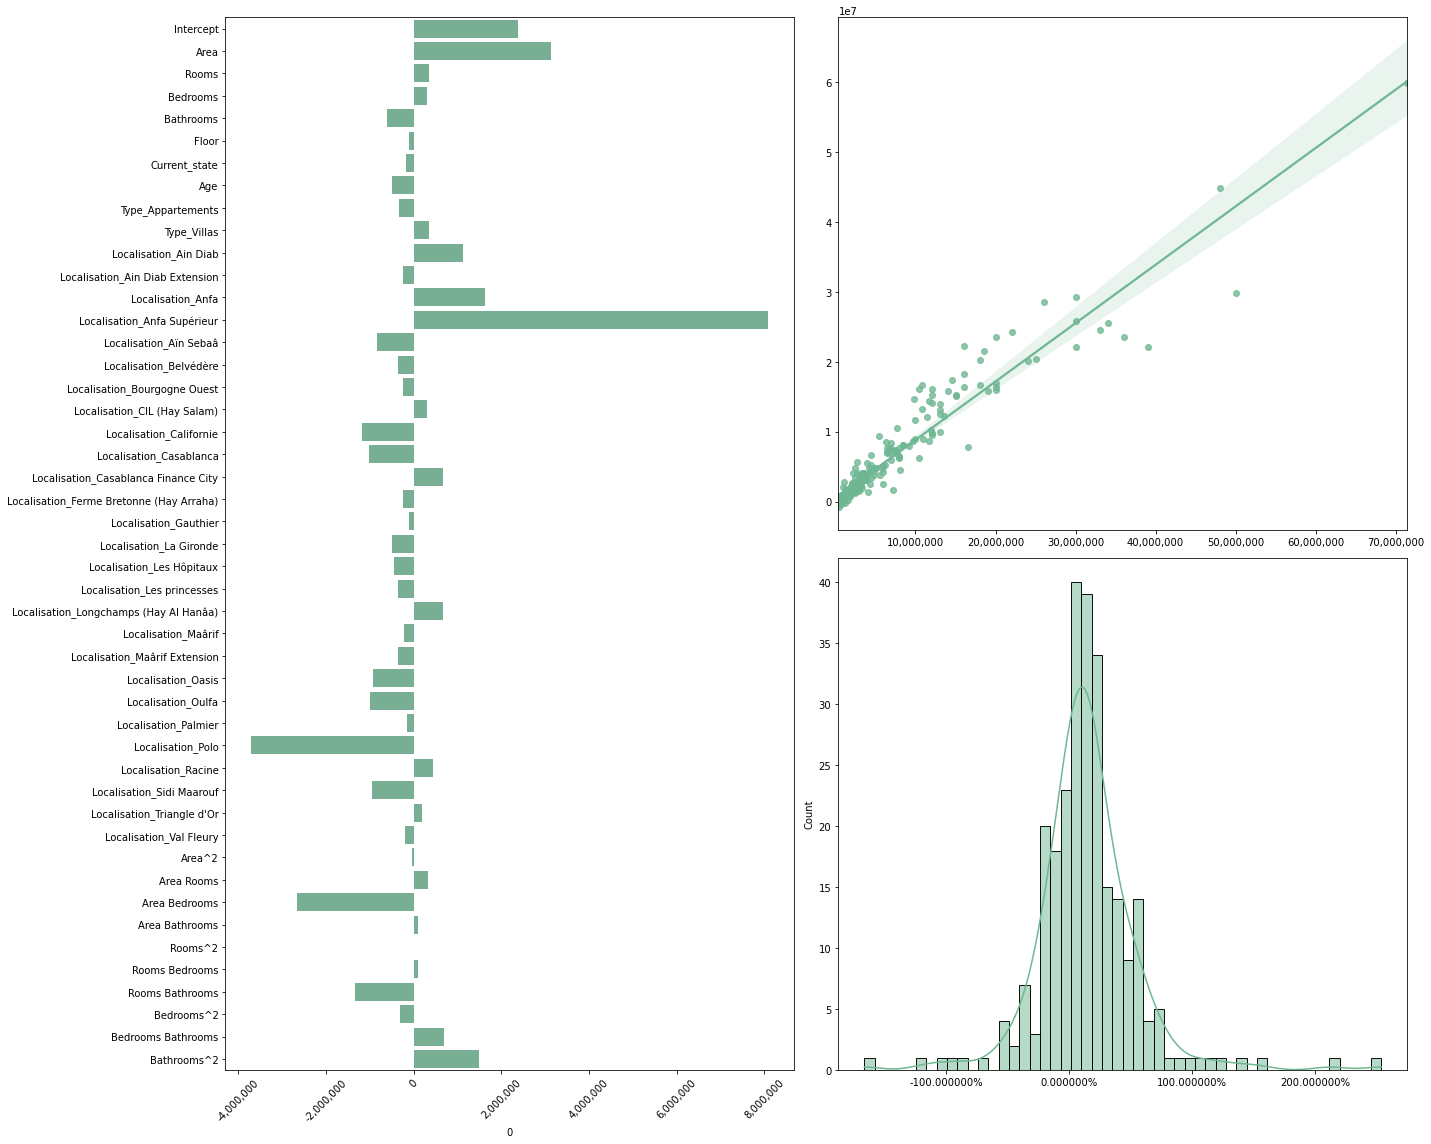

In [31]:
#Use a Ridge regression with polynomial features to introduce regularization with scaled data
ridge = Ridge()
ridge_hyparams = {'alpha':[0.001,0.01,0.1,1,3,5,10]}
poly_ridge_regression = GridSearchCV(ridge,ridge_hyparams,cv = 5)
evaluate_linear_model(X_train_poly_scaled,y_train,X_test_poly_scaled,y_test,poly_ridge_regression,grid=True)

In [53]:
def evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score: {reg.score(X_train,y_train):.2f}')
    print(f'Test set score: {reg.score(X_test,y_test):.2f}')
    importances_matrix = pd.DataFrame(reg.feature_importances_.reshape(1,-1),columns = X_dummies.columns)
    display(importances_matrix)
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])
    
    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = importances_matrix.columns,x = importances_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    
    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    
    plt.tight_layout()
    plt.show()

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Best estimator parameters : {'max_depth': 10, 'n_estimators': 200}
train RMSE : 948862.91
test RMSE : 2779314.49
train MAPE : 0.0973
test MAPE : 0.1747
Training set score: 0.98
Test set score: 0.90


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.929415,0.009902,0.006261,0.009211,0.00085,0.01035,0.006803,0.000285,0.000435,0.003133,...,0.000046,0.00001,0.000465,0.000299,0.000022,0.004681,0.000295,0.000271,0.000049,0.000006


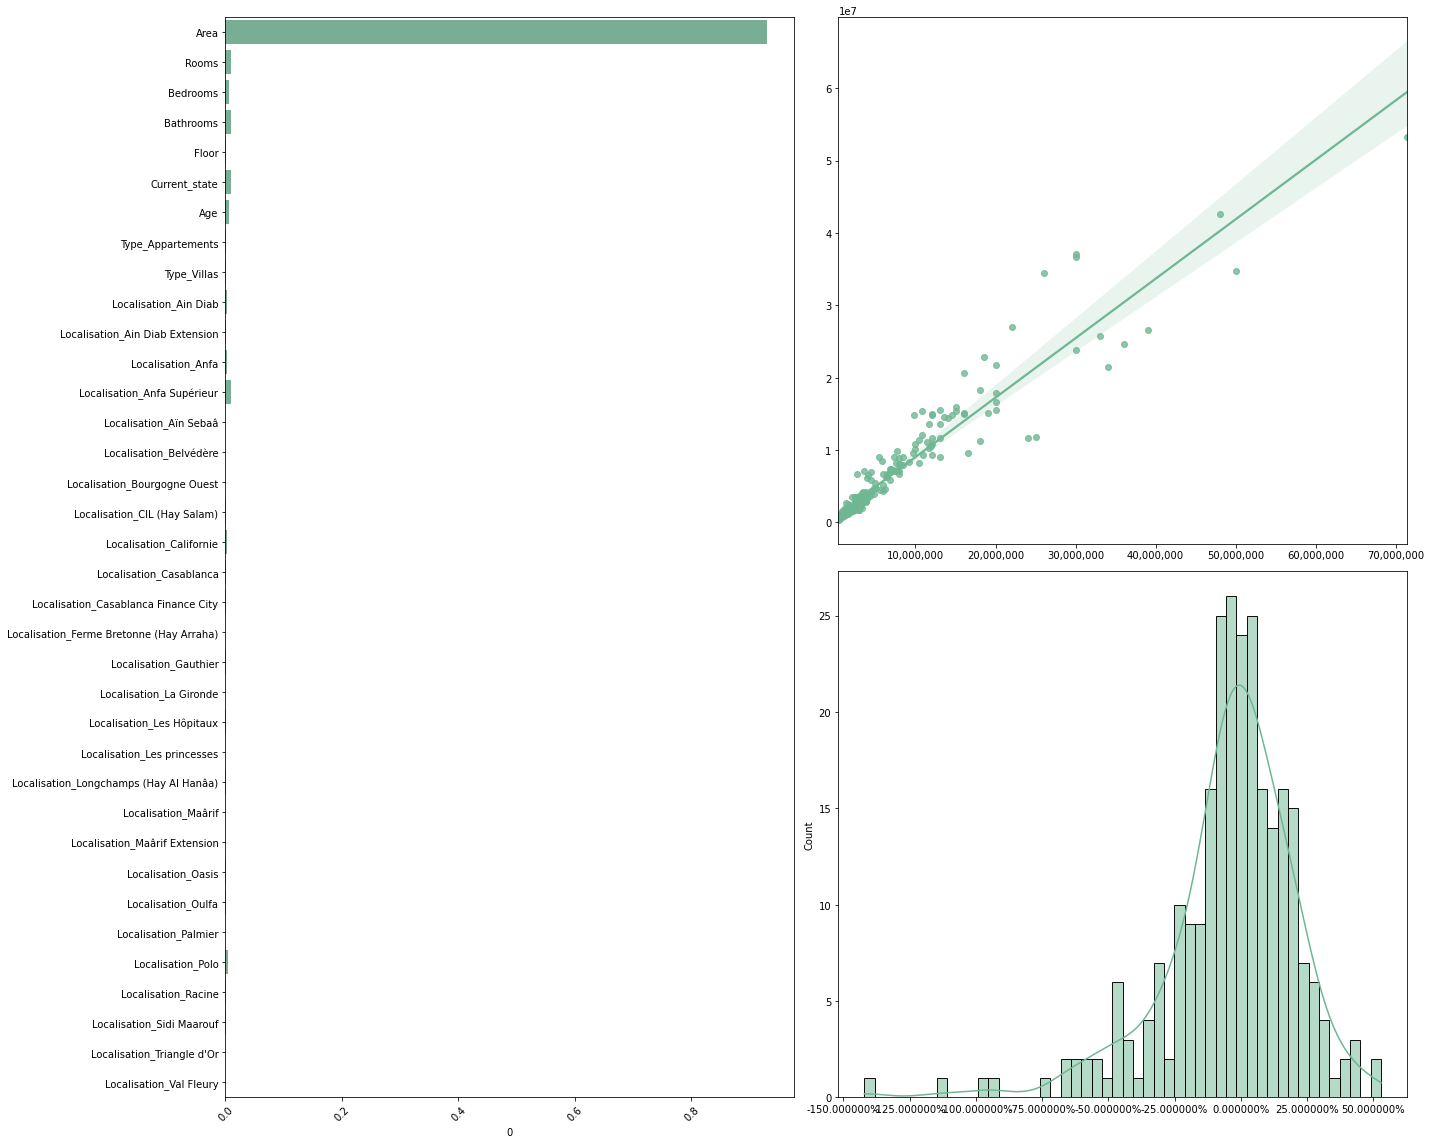

In [54]:
#Use a random forest regressor
rf = RandomForestRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [5,10]}
random_forest = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,random_forest,grid=True)

Best estimator parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
train RMSE : 877020.08
test RMSE : 2582786.06
train MAPE : 0.1497
test MAPE : 0.1882
Training set score: 0.99
Test set score: 0.91


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.913822,0.003515,0.006808,0.009162,0.011951,0.003207,0.004048,0.010972,0.001496,0.002884,...,0.0,0.0,0.000373,0.000276,0.0,0.005214,0.000448,0.000066,0.000043,0.0


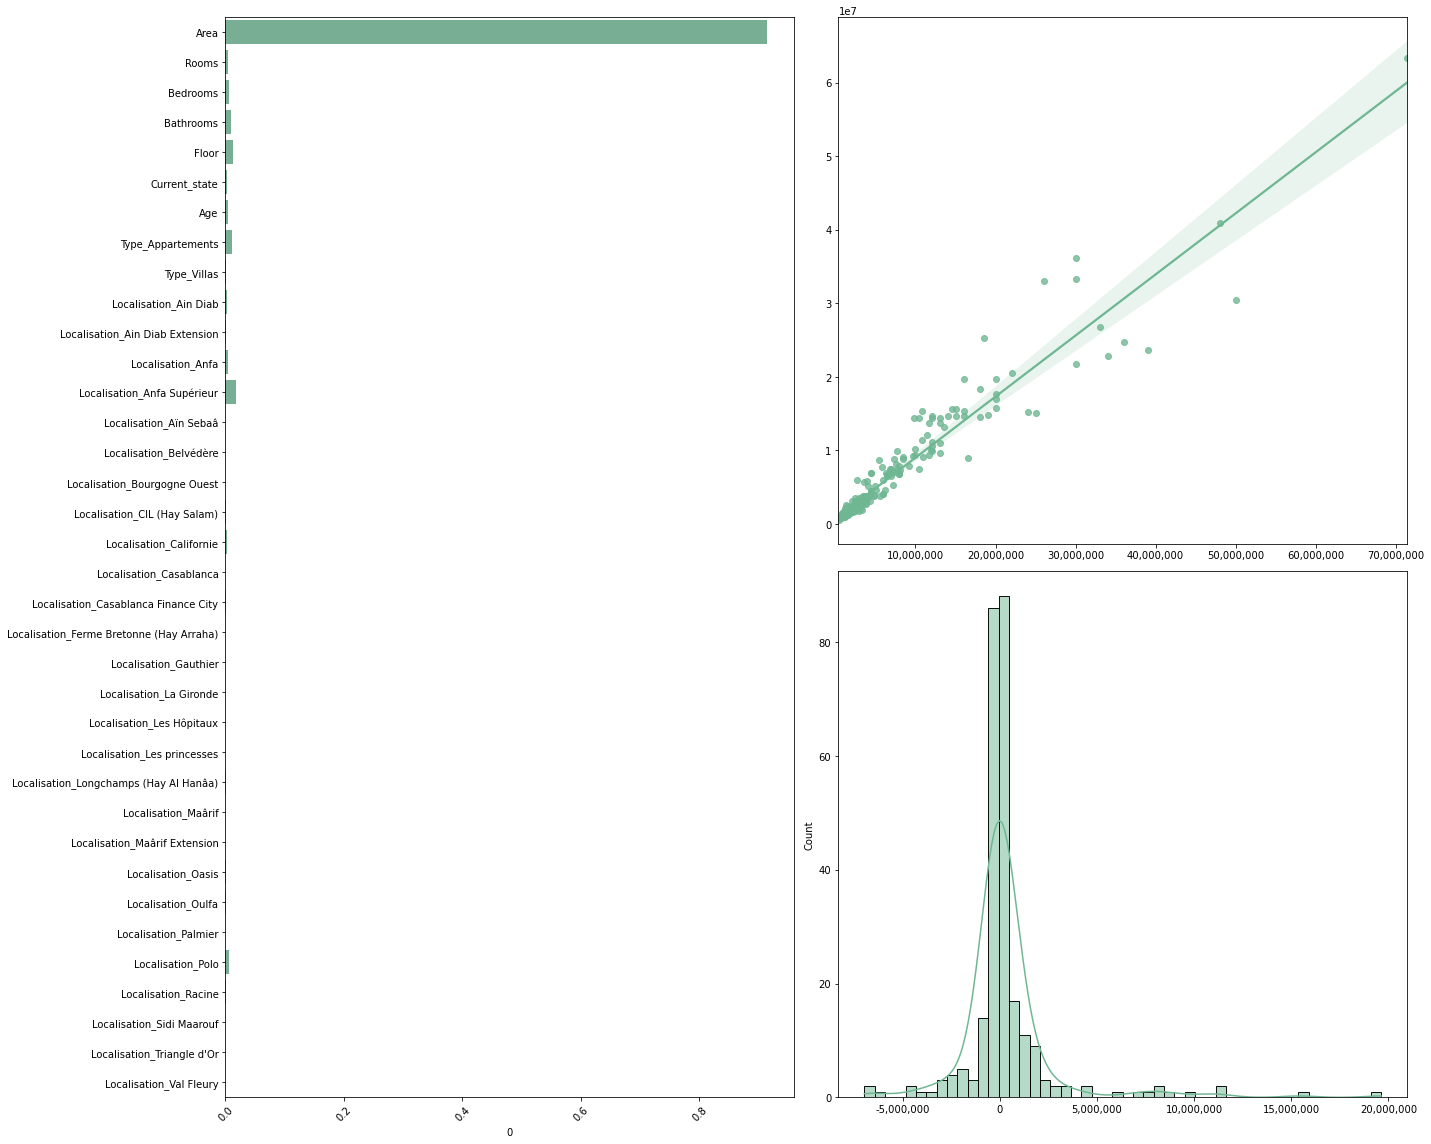

In [50]:
#Use a gradient boosting regressor
rf = GradientBoostingRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [3,5,10,15],'learning_rate':[0.05,0.1,0.5]}
gradient_boosted_regressor = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,gradient_boosted_regressor,grid=True)

### Build model for predicting Price_m2 

In [27]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price_m2']
df_model = df[cols_to_keep]

In [28]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms             59
Bedrooms           3
Bathrooms         43
Floor            297
Current_state    149
Age              535
Price_m2           0
dtype: int64

In [29]:
#drop listings where all four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [31]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price_m2'].values 

In [33]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)

In [34]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [35]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [36]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

RMSE : 3180.69
Training set score (R^2): 0.49
Test set score (R^2): 0.48


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,20276.729635,-2.278298,-180.111928,-438.419077,389.237799,62.839992,-599.684357,-370.902747,-1841.273809,1841.273809,...,677.513019,-244.516972,-31.660545,-6382.379395,929.66222,-4572.612321,4491.071793,-1830.608712,2591.595822,-201.358438


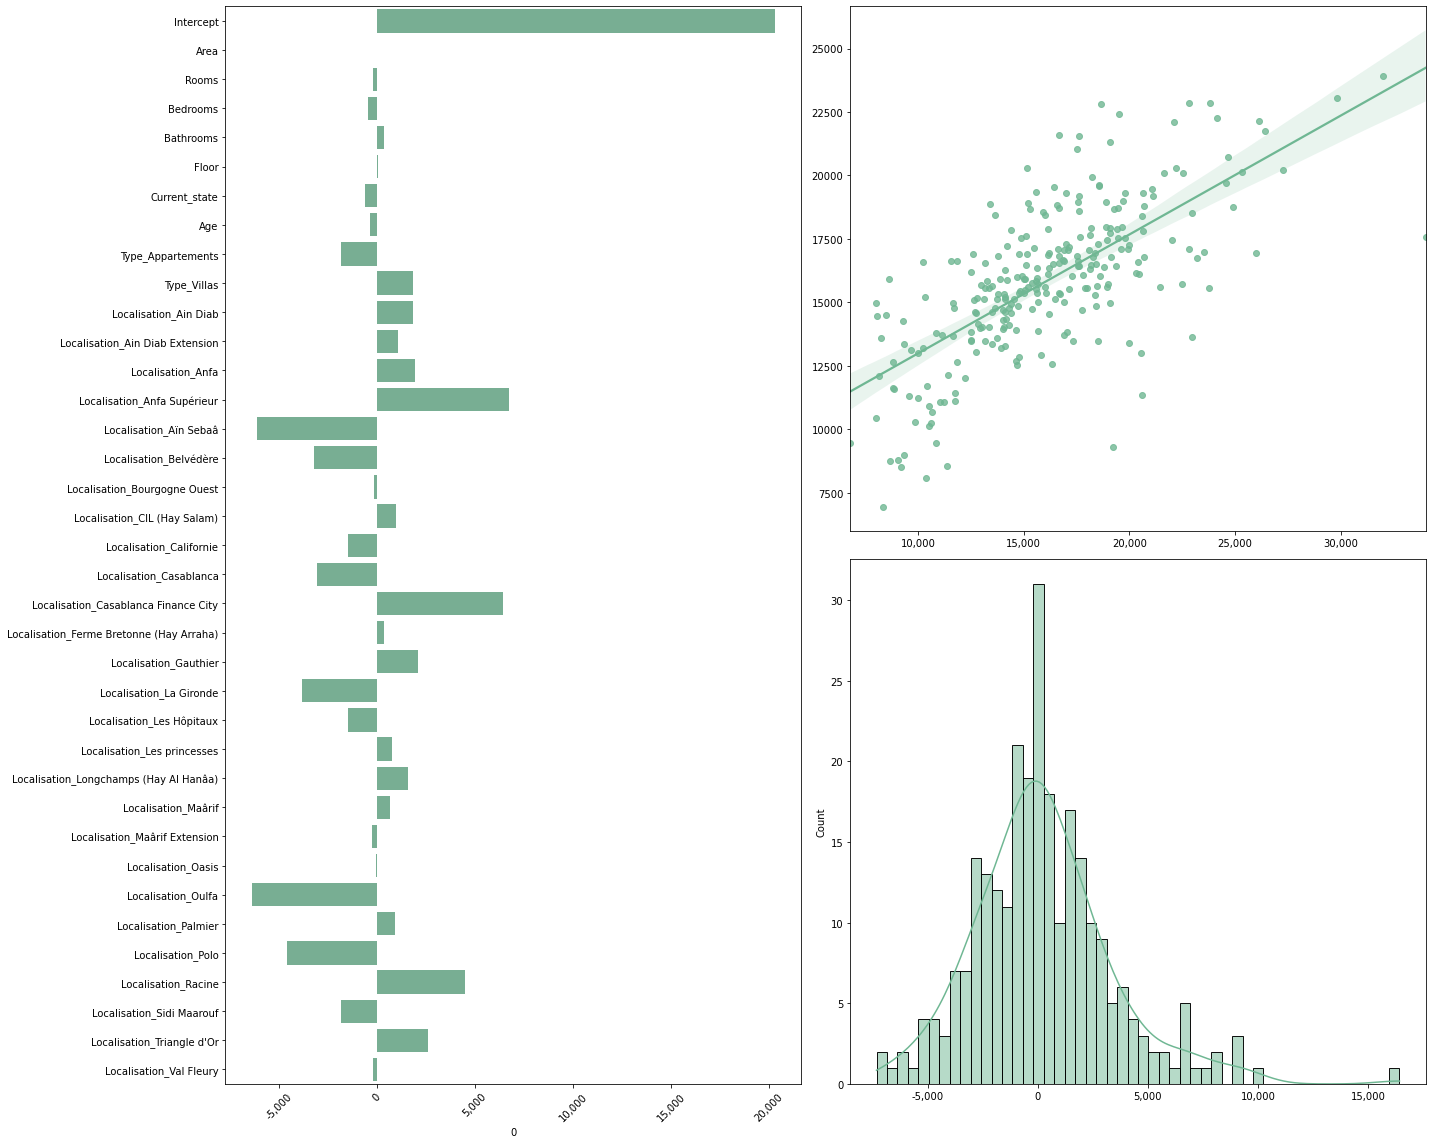

In [37]:
#Evaluate multivariate ols linear regression


reg = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,reg)

In [39]:
#Introduce polynomial features


In [141]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [142]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape

(887, 50)

In [143]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [148]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

X_train_poly_scaled

,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,1.152038,1.00,0.5,2.0,-0.50,-2.0,-0.75,-1.0,1.0,0.0,...,1.514851,1.321871,1.060645,1.590638,1.200,1.111111,1.833333,0.583333,1.250,2.4
1,3.963950,1.25,0.5,2.0,-0.50,0.0,0.25,-1.0,1.0,0.0,...,12.062821,4.570997,3.375484,4.883892,1.625,1.333333,2.166667,0.583333,1.250,2.4
2,0.186520,0.25,0.0,1.0,0.50,-1.0,0.50,0.0,0.0,0.0,...,0.134578,0.144733,0.125806,0.260670,0.225,0.166667,0.416667,0.000000,0.375,1.0
3,-0.108150,0.00,0.0,1.0,-0.25,-1.0,-0.75,0.0,0.0,0.0,...,-0.058449,-0.079358,-0.056129,0.001836,0.000,0.000000,0.166667,0.000000,0.375,1.0
4,0.963950,1.00,0.5,2.0,-0.50,1.0,0.25,-1.0,1.0,0.0,...,1.156097,1.140482,0.905806,1.370353,1.200,1.111111,1.833333,0.583333,1.250,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,-0.061129,0.00,0.0,0.0,0.50,0.0,0.25,0.0,0.0,0.0,...,-0.034803,-0.056684,-0.027097,-0.083525,0.000,0.000000,-0.166667,0.000000,0.000,0.0
616,-0.133229,-0.25,-0.5,0.0,-0.25,-1.0,-0.75,0.0,0.0,0.0,...,-0.069948,-0.134908,-0.145806,-0.125746,-0.175,-0.333333,-0.333333,-0.416667,-0.250,0.0
617,1.020376,0.25,0.5,1.0,-0.50,-1.0,0.00,-1.0,1.0,0.0,...,1.259158,0.647331,0.952258,0.993116,0.225,0.444444,0.416667,0.583333,0.750,1.0
618,3.543887,0.25,0.5,0.0,-0.50,0.0,-0.25,-1.0,1.0,0.0,...,9.869589,2.168351,3.029677,2.027536,0.225,0.444444,0.000000,0.583333,0.250,0.0


RMSE : 3163.78
Training set score (R^2): 0.54
Test set score (R^2): 0.48


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,14334.120081,-1130.564723,175.036263,-334.107591,-665.791699,284.397584,-526.842217,-1562.528493,-2600.477602,2600.477602,...,191.260851,349.262796,-36.034238,-248.988333,1198.61733,-2080.097197,-759.337839,1314.688702,-707.022824,1976.068166


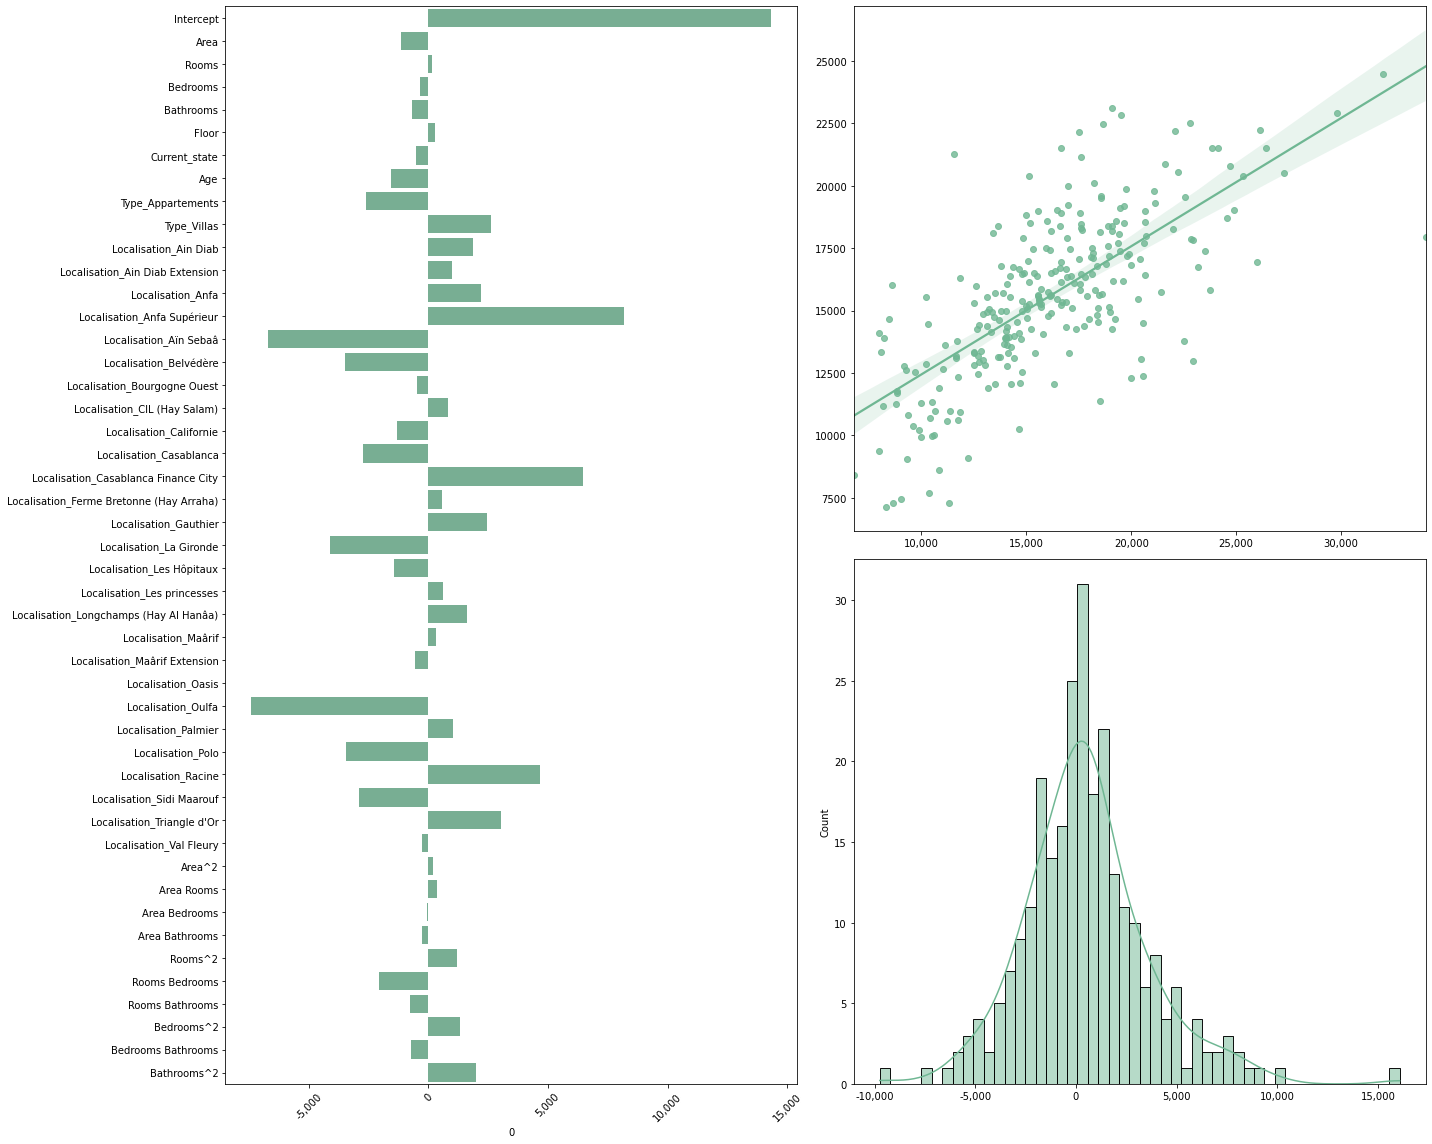

In [150]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

reg = LinearRegression()
reg.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,reg)

Best estimator parameters : {'max_depth': 10, 'max_features': 10, 'n_estimators': 200}
RMSE : 3353.70
Training set score: 0.68
Test set score: 0.42


,Area,Rooms,Bedrooms,Bathrooms,Floor,Current_state,Age,Type_Appartements,Type_Villas,Localisation_Ain Diab,...,Localisation_Maârif,Localisation_Maârif Extension,Localisation_Oasis,Localisation_Oulfa,Localisation_Palmier,Localisation_Polo,Localisation_Racine,Localisation_Sidi Maarouf,Localisation_Triangle d'Or,Localisation_Val Fleury
0,0.170112,0.052095,0.042889,0.057852,0.043109,0.041018,0.080634,0.014181,0.012451,0.026017,...,0.004411,0.0014,0.00712,0.111455,0.000721,0.02361,0.075431,0.011477,0.003625,0.000228


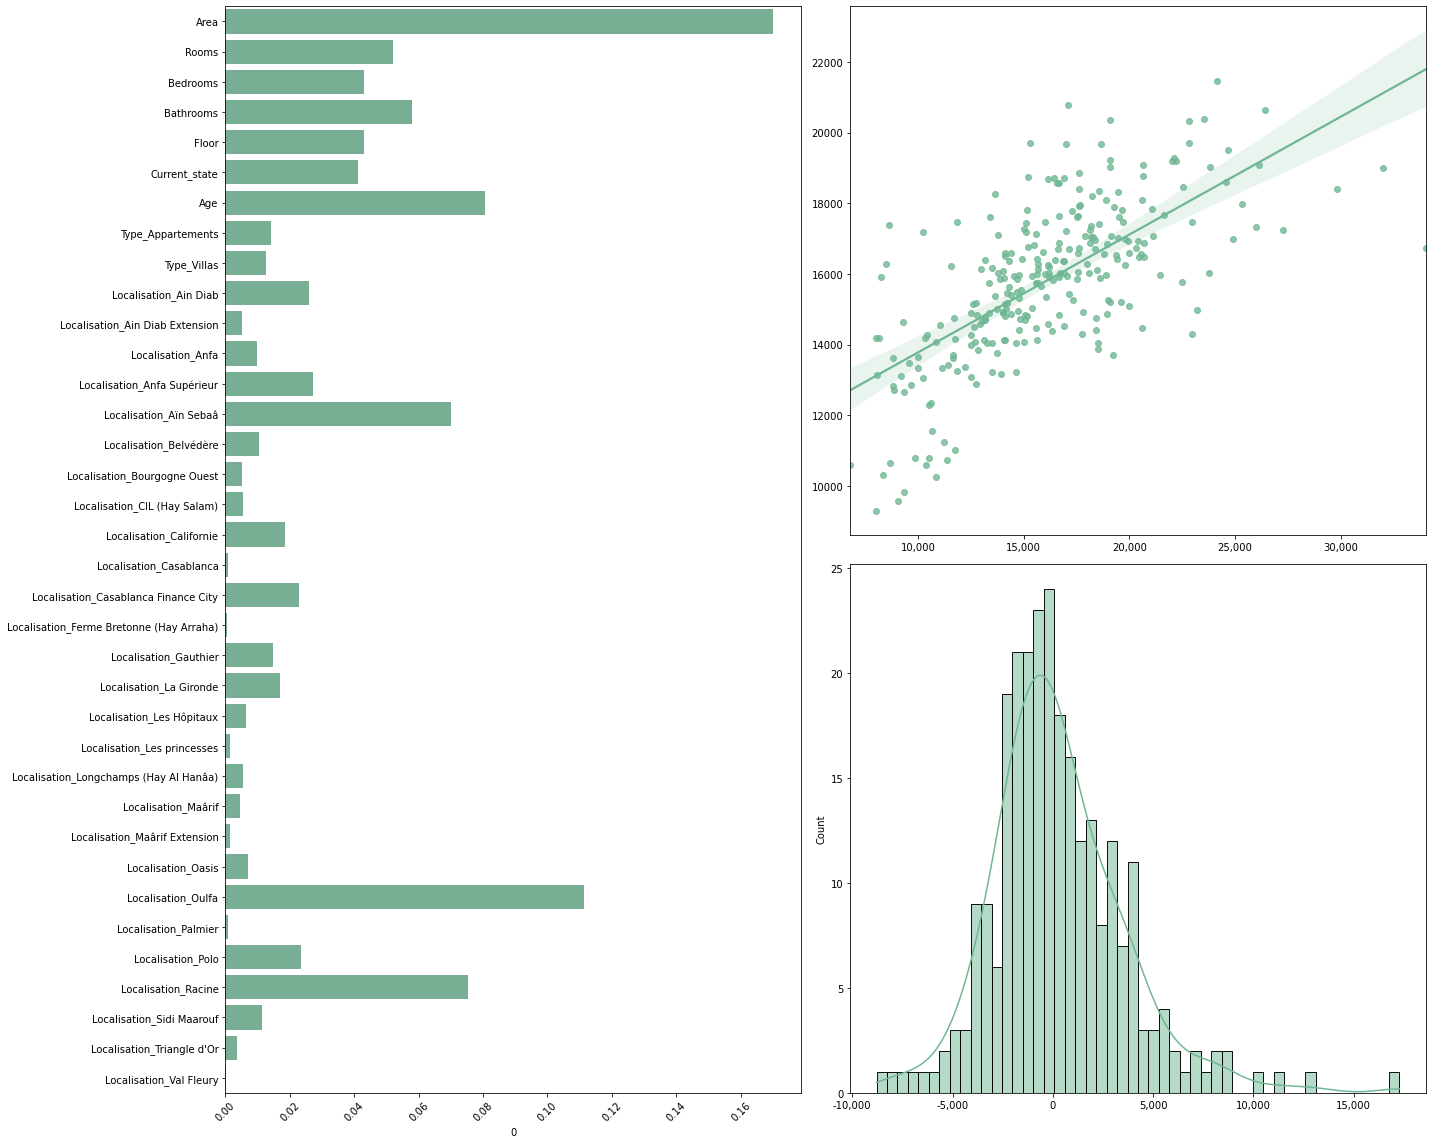

In [38]:
#Use a random forest regressor
rf = RandomForestRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [5,10],'max_features':[10]}
reg = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=True)